In [1]:
import matplotlib.pyplot as plt
import numpy as np
from random import random, shuffle

from scipy.integrate import simps
import pandas as pd
import sys
import math
from mpl_toolkits import mplot3d
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
import seaborn as sns

sys.path.append("..")
from utils.load_las_data import normalize_z_with_minz_in_a_radius

from config import args
from utils.load_las_data import *
from utils.useful_functions import *
import os
import numpy as np; np. set_printoptions(suppress=True);  # display values without scientific notation
import pandas as pd
from laspy.file import File
from sklearn.neighbors import NearestNeighbors
import warnings
import random

Arguments were imported in DEV mode


In [2]:
def load_and_clean_single_las(las_filename):
    """Load a LAD file into a np.array, convert coordinates to meters, clean a few anomalies in plots."""
    # Parse LAS files
    las = File(las_filename, mode="r")
    x_las = las.X / 100  # we divide by 100 as all the values in las are in cm
    y_las = las.Y / 100
    z_las = las.Z / 100
    r = las.Red
    g = las.Green
    b = las.Blue
    nir = las.nir
    intensity = las.intensity
    return_num = las.return_num
    num_returns = las.num_returns
    points_nparray = np.asarray(
        [x_las, y_las, z_las, r, g, b, nir, intensity, return_num, num_returns]
    ).T

    # There is a file with 2 points 60m above others (maybe birds), we delete these points
    if las_filename.endswith("Releve_Lidar_F70.las"):
        points_nparray = points_nparray[points_nparray[:, 2] < 640]
    # We do the same for the intensity
    if las_filename.endswith("POINT_OBS8.las"):
        points_nparray = points_nparray[points_nparray[:, -2] < 32768]
    if las_filename.endswith("Releve_Lidar_F39.las"):
        points_nparray = points_nparray[points_nparray[:, -2] < 20000]

    # get the center of a rectangle bounding the points
    xy_centers = [
        (x_las.max() - x_las.min()) / 2.0,
        (y_las.max() - y_las.min()) / 2.0,
    ]
    return points_nparray, xy_centers

In [3]:
def load_my_data(args):

    # We open las files and create a training dataset
    nparray_clouds_dict = {}  # dict to store numpy array with each plot separately
    xy_centers_dict = (
        {}
    )  # we keep track of plots means to reverse the normalisation in the future

    # We iterate through las files and transform them to np array
    las_filenames = get_files_of_type_in_folder(args.las_placettes_folder_path, ".las")


    all_points_nparray = np.empty((0, len(args.input_feats) - 1))
    for las_filename in las_filenames:
        # Parse LAS files
        points_nparray, xy_centers = load_and_clean_single_las(las_filename)
#         points_nparray = transform_features_of_plot_cloud(
#             points_nparray, args
#         )
        all_points_nparray = np.append(all_points_nparray, points_nparray, axis=0)
        plot_name = get_filename_no_extension(las_filename)
        nparray_clouds_dict[plot_name] = points_nparray
        xy_centers_dict[plot_name] = xy_centers

    return all_points_nparray, nparray_clouds_dict, xy_centers_dict

In [4]:
def select_my_clouds(nparray_clouds_dict):
    # F49 = nparray_clouds_dict["Releve_Lidar_F49"][:,:3]
    # F68 = nparray_clouds_dict["Releve_Lidar_F68"][:,:3]  # Vm everywhere
    # OBS_2021_6 = nparray_clouds_dict["2021_POINT_OBS6"][:,:3]  # "hyper flag en termes de MNT"
    # F20 = nparray_clouds_dict["Releve_Lidar_F20"][:,:3]  # "hyper flag en termes de MNT"

    plots_of_interest = [
        "Releve_Lidar_F103",
        "Releve_Lidar_F99",
        "Releve_Lidar_F107",

#         "POINT_OBS101",
#         "Releve_Lidar_F69",
#         "2021_POINT_OBS9",  # grass 100%, high slope: 0-3m to 0-0.4cm slope with 1.5
#         "Releve_Lidar_F49",  # loads of high vegetation. Ok with 1.5m
#         "Releve_Lidar_F68",  # dense bushes. Ok with 1.5 : adds contrast.
#         "2021_POINT_OBS6",  # 75% grass (subestimation of model). might add contrats linked to grass
#         "Releve_Lidar_F20",  # 75% grass, 25% mid veg. ok,
#         "2021_POINT_OBS59",
    ]
    # focus on medium veg
    plots_of_interest = plots_of_interest + []
    selection = {
        key: value
        for key, value in nparray_clouds_dict.items()
        if key in plots_of_interest
    }
    return selection

In [5]:
# %matplotlib notebook
def plot_norm_impact(cloud, cloud_norm, title, output_path):
    cloud[:,2] = cloud[:,2] - np.min(cloud[:,2])
    
    fig = plt.figure(figsize=plt.figaspect(0.8) * 2.5)
    fig.patch.set_facecolor('#E0E0E0')
    fig.patch.set_alpha(0.7)
    fig.suptitle(title)

    # without norm
    ax = fig.add_subplot(2, 2, 1, projection="3d")
    ax.scatter3D(cloud[:, 0], cloud[:, 1], cloud[:, 2], c=cloud[:, 2] + 0.5)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    ax.view_init(elev=0., azim=0)

    ax = fig.add_subplot(2, 2, 3)
    sns.distplot(cloud[:,2],ax=ax, kde=False)


    # with norm
    cloud_norm[:,2] = cloud_norm[:,2] - np.min(cloud_norm[:,2])
    ax = fig.add_subplot(2, 2, 2, projection="3d")
    ax.scatter3D(cloud_norm[:, 0], cloud_norm[:, 1], cloud_norm[:, 2], c=cloud_norm[:, 2] + 0.5)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    ax.view_init(elev=0., azim=0)

    ax = fig.add_subplot(2, 2, 4)
    sns.distplot(cloud_norm[:,2],ax=ax, kde=False)

    plt.tight_layout()
    plt.savefig(output_path, dpi = 100, facecolor=fig.get_facecolor(), edgecolor='none')

### Fonctionnal code to integrate is here 

In [6]:
DIM_METERS = 20


def center_plot(cloud, xy_center):
    """Center the cloud to 0, also return the initial xymin to decenter the cloud"""
    cloud[:, :2] = cloud[:, :2] - xy_center
    return cloud


def decenter_plot(cloud, xy_center):
    cloud[:, :2] = cloud[:, :2] + xy_center
    return cloud


def xy_to_polar_coordinates(xy):
    r = np.sqrt((1.0 * xy * xy).sum(axis=1))
    teta = np.arctan2(
        xy[:, 1], xy[:, 0]
    )  # -pi, pi around (0,0) to (1,0). y and x are args in this order.
    rteta = np.stack([r, teta], axis=1)
    return rteta


def polar_coordinates_to_xy(rteta):
    x = rteta[:, 0] * np.cos(rteta[:, 1])
    y = rteta[:, 0] * np.sin(rteta[:, 1])
    xy = np.stack([x, y], axis=1)
    return xy


def create_buffer_points(cloud, ring_thickness_meters):
    """cloud is centered with xy as first coordinates in meters."""
    candidates_polar = cloud.copy()
    candidates_polar[:, :2] = xy_to_polar_coordinates(candidates_polar[:, :2])
    candidates_polar = candidates_polar[
        candidates_polar[:, 0] > (DIM_METERS // 2 - ring_thickness_meters)
    ]  # points in external ring
    candidates_polar[:, 0] = candidates_polar[:, 0] + 2 * (
        abs(DIM_METERS // 2 - candidates_polar[:, 0])
    )  # use border of plot as a mirror
    candidates_polar[:, :2] = polar_coordinates_to_xy(candidates_polar[:, :2])
    return candidates_polar


# TRUE VERSION
def normalize_z_with_smooth_spline(
    cloud, xy_center, pix_size, ring_thickness_meters, s=None, max_n_iter=10
):
    """From a regular grid, find lowest point in each cell/pixel and use them to approximate
    the DTM with a spline. Then, normalize z by flattening the ground using the DTM.
    """
    norm_cloud = cloud.copy()
    cloud_z_min = norm_cloud[:, 2].min()

    # center in order to use polar coordinate
    norm_cloud = center_plot(norm_cloud, xy_center)

    # create buffer
    buffer_points = create_buffer_points(norm_cloud, ring_thickness_meters)
    extended_cloud = np.concatenate([norm_cloud, buffer_points])

    # fit
    xy_quantified = (
        extended_cloud[:, :2] // pix_size + 0.5
    ) * pix_size  # quantify (and center) coordinates
    xy_pairs, z_argmin = npi.group_by(xy_quantified).argmin(extended_cloud[:, 2])
    extended_cloud = extended_cloud[z_argmin]

    for i in range(max_n_iter):
        sbs = SmoothBivariateSpline(
            extended_cloud[:, 0],
            extended_cloud[:, 1],
            extended_cloud[:, 2],
            kx=3,
            ky=3,
            s=s,
        )

        # predict on normcloud and correct predictions under cloud_z_min to avoid divergence
        norm_cloud_iter = norm_cloud.copy()
        pointwise_spline = sbs(norm_cloud_iter[:, 0], norm_cloud_iter[:, 1], grid=False)
        pointwise_spline[pointwise_spline < cloud_z_min] = cloud_z_min
        norm_cloud_iter[:, 2] = norm_cloud_iter[:, 2] - pointwise_spline

        # find points falling below spline surface and add them to points used to fit the spline
        mask_below_spline = norm_cloud_iter[:, 2] < 0
        q = np.quantile(norm_cloud_iter[mask_below_spline, 2], 0.1)  # lowest 10%
        if (mask_below_spline.sum() == 0) or (q > -0.05):
            break

        points_below_spline = norm_cloud[mask_below_spline]
        extended_cloud = np.concatenate([extended_cloud, points_below_spline])

    # Normalize with finalized Spline
    pointwise_spline = sbs(norm_cloud[:, 0], norm_cloud[:, 1], grid=False)
    pointwise_spline[pointwise_spline < cloud_z_min] = cloud_z_min
    norm_cloud[:, 2] = norm_cloud[:, 2] - pointwise_spline
    
    # Set to zero the ones below the spline
    mask_below_spline = norm_cloud[:, 2] < 0
    norm_cloud[mask_below_spline, 2] = 0.0

    # get back to initial coordinate system
    norm_cloud = decenter_plot(norm_cloud, xy_center)
    return norm_cloud


# DEV VERSION
# def normalize_z_with_smooth_spline(
#     cloud, xy_center, pix_size, ring_thickness_meters, s=None, max_n_iter = 10
# ):
#     """From a regular grid, find lowest point in each cell/pixel and use them to approximate
#     the DTM with a spline. Then, normalize z by flattening the ground using the DTM.
#     """
#     norm_cloud = cloud.copy()

#     # center in order to use polar coordinate
#     norm_cloud = center_plot(norm_cloud, xy_center)

#     # create buffer
#     buffer_points = create_buffer_points(norm_cloud, ring_thickness_meters)
#     extended_cloud = np.concatenate([norm_cloud, buffer_points])

#     # fit
#     xy_quantified = (
#         extended_cloud[:, :2] // pix_size + 0.5
#     ) * pix_size  # quantify (and center) coordinates
#     xy_pairs, z_argmin = npi.group_by(xy_quantified).argmin(extended_cloud[:, 2])
#     extended_cloud = extended_cloud[z_argmin]

#     for i in range(max_n_iter):
#         sbs = SmoothBivariateSpline(
#             extended_cloud[:, 0],
#             extended_cloud[:, 1],
#             extended_cloud[:, 2],
#             kx=3,
#             ky=3,
#             s=s,
#         )

#         # predict on normcloud
#         norm_cloud_iter = norm_cloud.copy()
#         norm_cloud_iter[:, 2] = norm_cloud_iter[:, 2] - sbs(
#             norm_cloud_iter[:, 0], norm_cloud_iter[:, 1], grid=False
#         )


#         # find points falling below spline surface and add them to points used to fit the spline
#         mask_below_spline = norm_cloud_iter[:, 2] < 0
#         q=np.quantile(norm_cloud_iter[mask_below_spline,2], 0.1) # lowest 10%
#         if (mask_below_spline.sum() == 0) or (q> -0.05) :
# #             print("BREAKING", norm_cloud_iter[idx_below_spline,2].min())
#             print(f"10% lowest are below : {q}")
#             print("breaking")
#             break

#         points_below_spline = norm_cloud[mask_below_spline]
#         extended_cloud = np.concatenate([extended_cloud, points_below_spline])

#         print(f"{i+1}/{max_n_iter} Points below : {points_below_spline.shape[0]}")


#     # Normalize with finalized Spline
#     norm_cloud[:, 2] = norm_cloud[:, 2] - sbs(
#             norm_cloud[:, 0], norm_cloud[:, 1], grid=False
#         )
#     if points_below_spline.shape[0] != 0:
#         points_below_spline = norm_cloud[norm_cloud[:, 2] < 0]
#         print(f"ERROR : some points still below {points_below_spline.shape[0]}")
#         sns.displot(points_below_spline[:, 2])
#         plt.title(f"iter {i+1}/10 shape neg points : {points_below_spline.shape[0]}")
#         plt.show()
#     # get back to initial coordinate system
#     norm_cloud = decenter_plot(norm_cloud, xy_center)
#     return norm_cloud

In [30]:
from scipy.interpolate import SmoothBivariateSpline
import numpy_indexed as npi

np.random.seed(0)
xy_center = np.array([500,500])
# fake data
xy = (
    np.random.random((1000, 2)) * DIM_METERS + xy_center
)  # 20*20 and with an offset that needs to be removed


def fxy(x, y):
    return -np.sin(y * 2) + np.cos(x * 2) * 2 + 2 * np.cos(x) * np.sin(x * 2)


z = fxy(xy[:, 0:1], xy[:, 1:2])
xyz = np.append(xy, z, axis=1)


# normalize_z_with_smooth_spline(xyz, xy_center, 1.5, 8, s=None)

# Try with real data

In [7]:
all_points_nparray, nparray_clouds_dict, xy_centers_dict = load_my_data(args)

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 9 and the array at index 1 has size 10

In [ ]:
selection = select_my_clouds(nparray_clouds_dict)

## Iterative way

In [115]:
my_cloud = selection["Releve_Lidar_F68"]
pix_size = 1.25
s = (20 // pix_size) ** 2 * 2
xy_min = my_cloud[:, :2].min(axis=0)
xy_center = xy_min + np.array([DIM_METERS // 2, DIM_METERS // 2])
norm_cloud = normalize_z_with_smooth_spline(my_cloud, xy_center, pix_size, 2, s=s)

KeyError: 'Releve_Lidar_F68'

## Save normalized clouds

./temp_cloud_iterative/NORM_SLINE_ITERATIVE_placette_Releve_Lidar_F99_pix_size_1.50.png


<IPython.core.display.Javascript object>


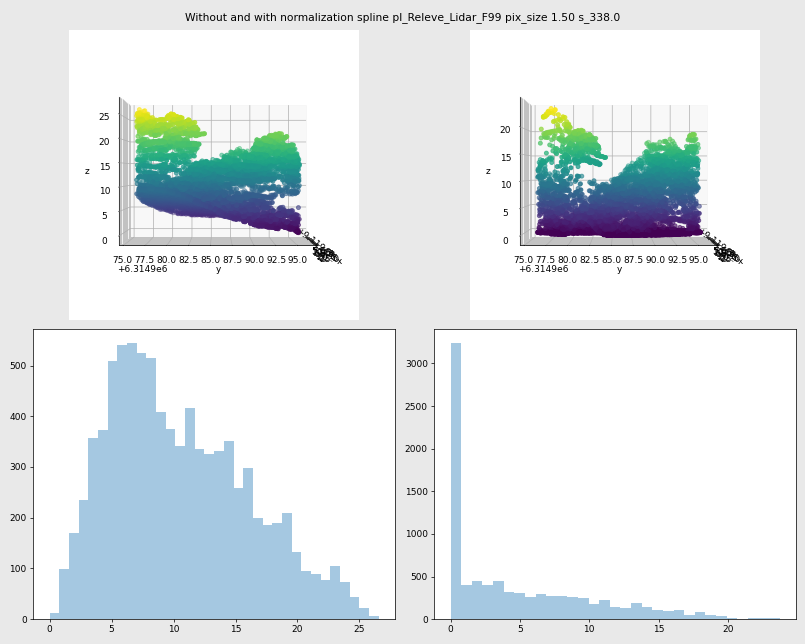

./temp_cloud_iterative/NORM_SLINE_ITERATIVE_placette_Releve_Lidar_F107_pix_size_1.50.png


<IPython.core.display.Javascript object>


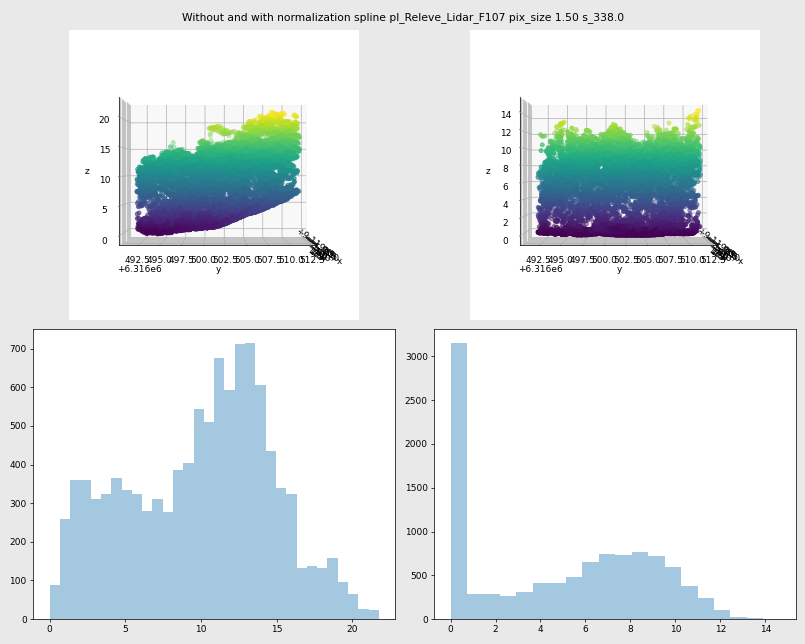

./temp_cloud_iterative/NORM_SLINE_ITERATIVE_placette_Releve_Lidar_F103_pix_size_1.50.png


<IPython.core.display.Javascript object>


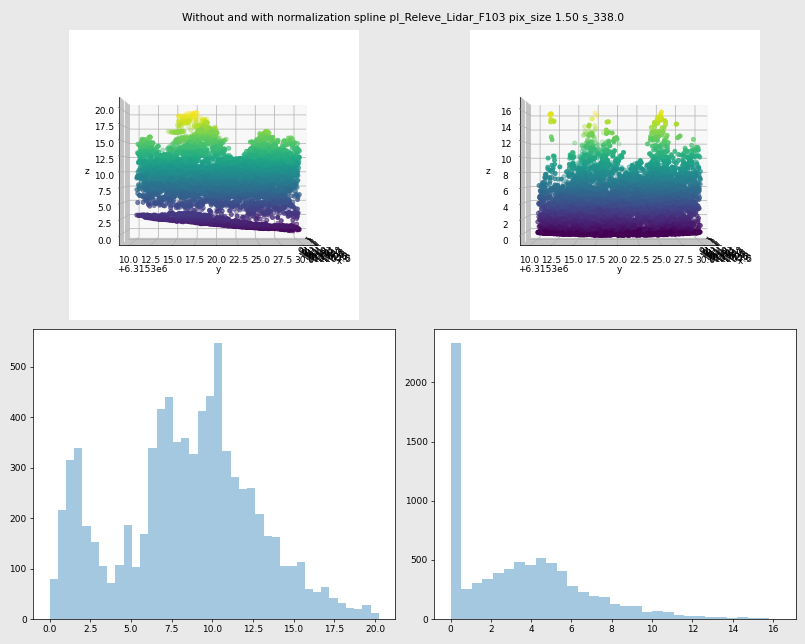

In [116]:
%matplotlib notebook
# range_pix_size = np.arange(0.5, 3, 0.25)
range_pix_size = [1.5]

for cloud_idx, (name, my_cloud) in enumerate(selection.items()):
    for pix_size in range_pix_size:
        
        # here approximate but should be real coordinates !
        xy_min = my_cloud[:, :2].min(axis=0)
        xy_center = xy_min + np.array([DIM_METERS // 2, DIM_METERS // 2])
        
        s = (20 // pix_size) ** 2 * 2
        cloud = my_cloud.copy()
        output_path = (
            f"./temp_cloud_iterative/NORM_SLINE_ITERATIVE_placette_{name}_pix_size_{pix_size:.02f}.png"
        )
        if not os.path.exists(os.path.dirname(output_path)):
            os.makedirs(os.path.dirname(output_path))
        cloud_norm = normalize_z_with_smooth_spline(cloud, xy_center, pix_size, 2, s=None)
        title = (
            f"Without and with normalization spline pl_{name} pix_size {pix_size:.02f} s_{s}"
        )
        print(output_path)
        plot_norm_impact(my_cloud, cloud_norm, title, output_path)
#     if cloud_idx>-1:
#         break

In [ ]:
cloud_norm = normalize_z_with_smooth_spline(cloud, pix_size, 15, s=s)

In [ ]:
cloud.shape

In [17]:
os.makedirs(os.path.dirname(output_path))

In [ ]:
def my_imshow(gr):
    plt.figure()
    plt.imshow(gr[:,:2])
    plt.colorbar()
my_imshow(buffer_points)

In [ ]:
candidates_polar = np.array([[-1.,2]])
candidates_polar[:, :2] = xy_to_polar_coordinates(candidates_polar[:, :2])
candidates_polar

<IPython.core.display.Javascript object>


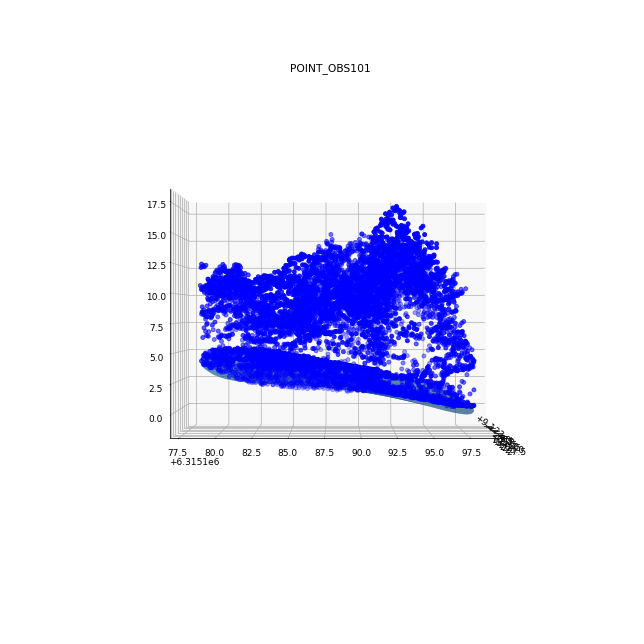

<IPython.core.display.Javascript object>


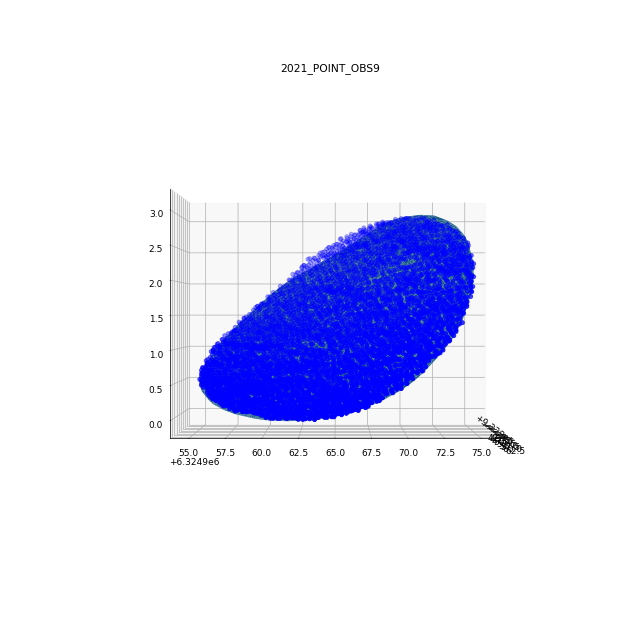

<IPython.core.display.Javascript object>


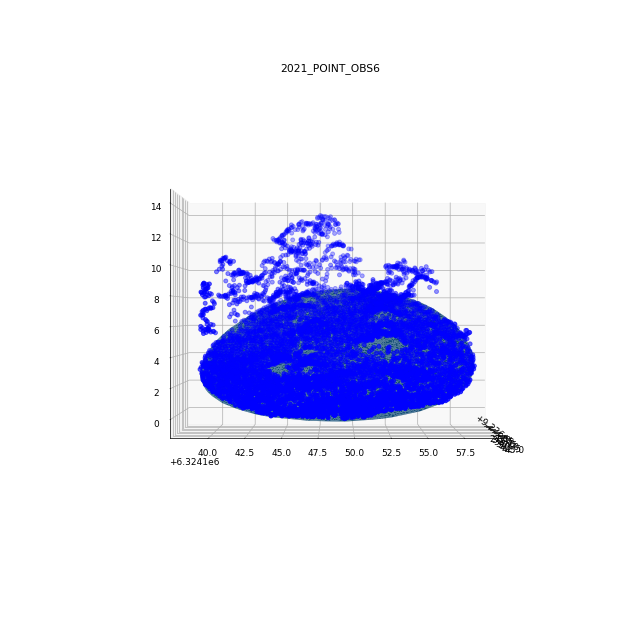

<IPython.core.display.Javascript object>


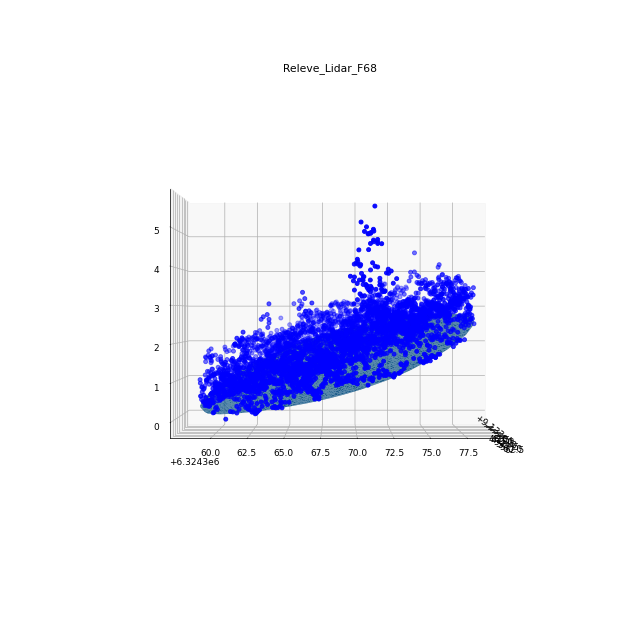

<IPython.core.display.Javascript object>


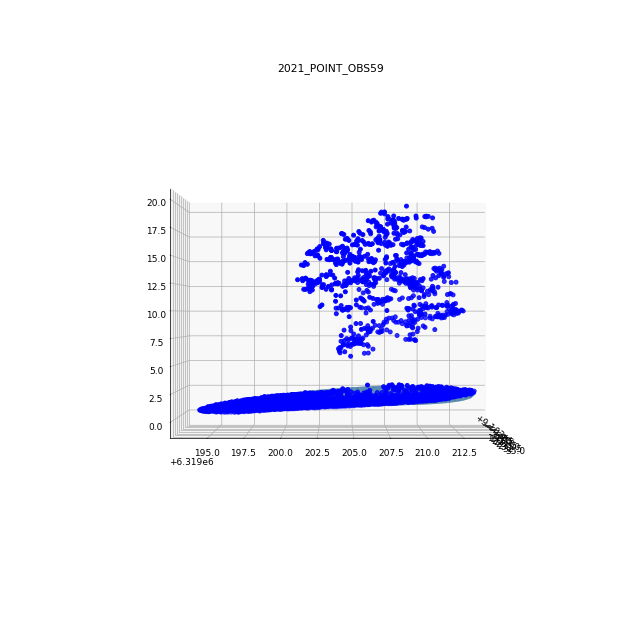

<IPython.core.display.Javascript object>


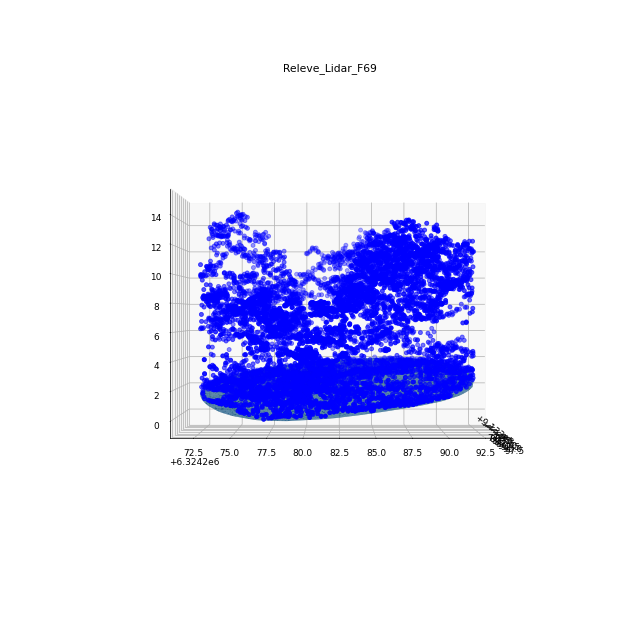

<IPython.core.display.Javascript object>


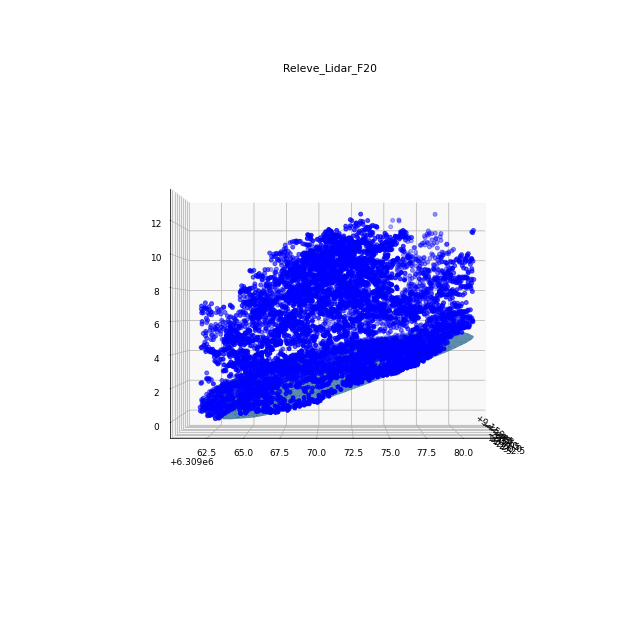

<IPython.core.display.Javascript object>


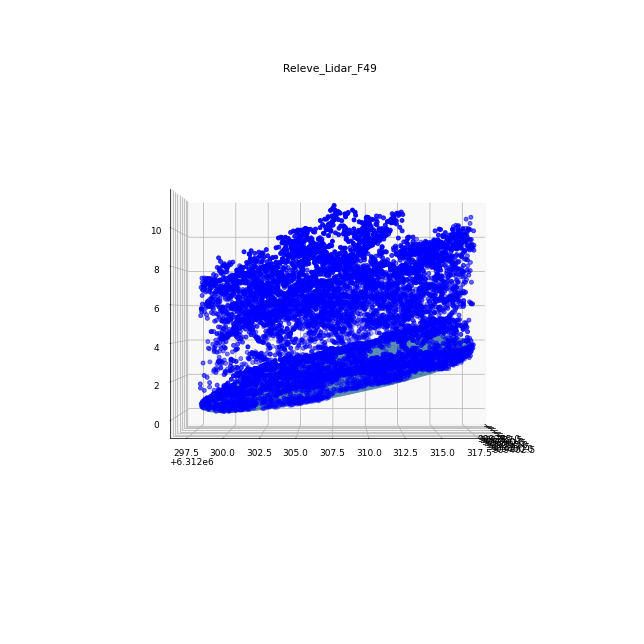

In [86]:
%matplotlib notebook
def visualize_spline_approx(cloud, title):
        
    # here approximate but should be real coordinates !
    xy_min = my_cloud[:, :2].min(axis=0)
    xy_center = xy_min + np.array([DIM_METERS // 2, DIM_METERS // 2])
#     s = (20 // pix_size) ** 2 * 2
    norm_cloud = normalize_z_with_smooth_spline(cloud,xy_center, 1.25, 2, s=None)
    cloud_dtm = norm_cloud.copy()
    cloud_dtm[:,2] = cloud[:,2] - cloud_dtm[:,2]

    # Visualize
    plt.figure(figsize=(10,10))
    ax = plt.axes(projection='3d')
    ax.plot_trisurf(cloud_dtm[:,0], cloud_dtm[:,1], cloud_dtm[:,2]);
    ax.scatter3D(cloud[:,0], cloud[:,1], cloud[:,2], c= "b", cmap='Greens');
    ax.view_init(elev=0., azim=0)
#     ax.set_zlim(-5, 5)
    plt.title(title)
    plt.show()


for key in selection:
    visualize_spline_approx(nparray_clouds_dict[key], key)
pass